In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import arviz as az

In [2]:
az.style.use('arviz-white')

# Gibbs sampling for the two-sample t-test

In this exercise we will use Gibbs sampling to test whether two populations have the same mean. Let the data from the first population be $Y_1,\dots,Y_n \sim\mbox{Normal}(\mu_Y,\sigma^2)$
and the second population be $Z_1,\dots,Z_m\sim\mbox{Normal}(\mu_Z,\sigma^2)$. The priors are:
* $\mu_Y,\mu_Z\sim\mbox{Normal}(\mu_0,\sigma_0^2)$
* $\sigma^2\sim\mbox{InvGamma}(a,b)$


Our goal is to compute the posterior of $\Delta=\mu_Y-\mu_Z$ and determine if $\Delta=0$ (the populations have the same mean) or not. To do these, we compute $\Delta$ at each iteration and then compute the posterior 95% credible set. To test out the code we will simulate data so we know the true values.

## Simulate data

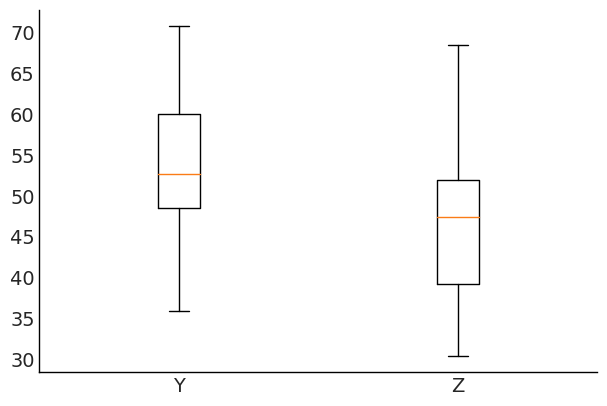

In [3]:
np.random.seed(42)

n = 20
m = 20
muY_true = 55
muZ_true = 50
s2_true = 100

Y = stats.norm(muY_true, (s2_true)**0.5).rvs(n)
Z = stats.norm(muZ_true, (s2_true)**0.5).rvs(n)

plt.boxplot((Y, Z), labels=('Y', 'Z'));

## Set the priors

In [4]:
mu_0 = 0
s2_0 = 1000
a = 0.01
b = 0.01

## Gibbs sampling

In [5]:
n_iters = 30000

# Initial values
muY = np.mean(Y)
muZ = np.mean(Z)
s2 = (np.var(Y) + np.var(Z)) / 2

muY_list = []
muZ_list = []
s2_list = []

for iter in range(1, n_iters):
    # sample muY|muZ,s2,Y,Z
    A = np.sum(Y) / s2 + mu_0 / s2_0
    B = n / s2 + 1 / s2_0
    muY = stats.norm(A/B, 1/B**0.5).rvs(1)[0]

    # sample muZ|muY,s2,Y,Z
    A = np.sum(Z) / s2 + mu_0 / s2_0
    B = m / s2 + 1 / s2_0
    muZ = stats.norm(A/B, 1/B**0.5).rvs(1)[0]

    # sample s2|muY,muZ,Y,Z
    A = n / 2 + m / 2 + a
    B = np.sum((Y-muY)**2)/2 + np.sum((Z-muZ)**2)/2+b
    s2 = stats.invgamma(A, scale=B).rvs(1)[0]

    # keep track of the results
    muY_list.append(muY)
    muZ_list.append(muZ)
    s2_list.append(s2)

keepers = {'muY': muY_list, 'muZ': muZ_list, 's2': s2_list,
           'delta': np.array(muY_list)-np.array(muZ_list)}

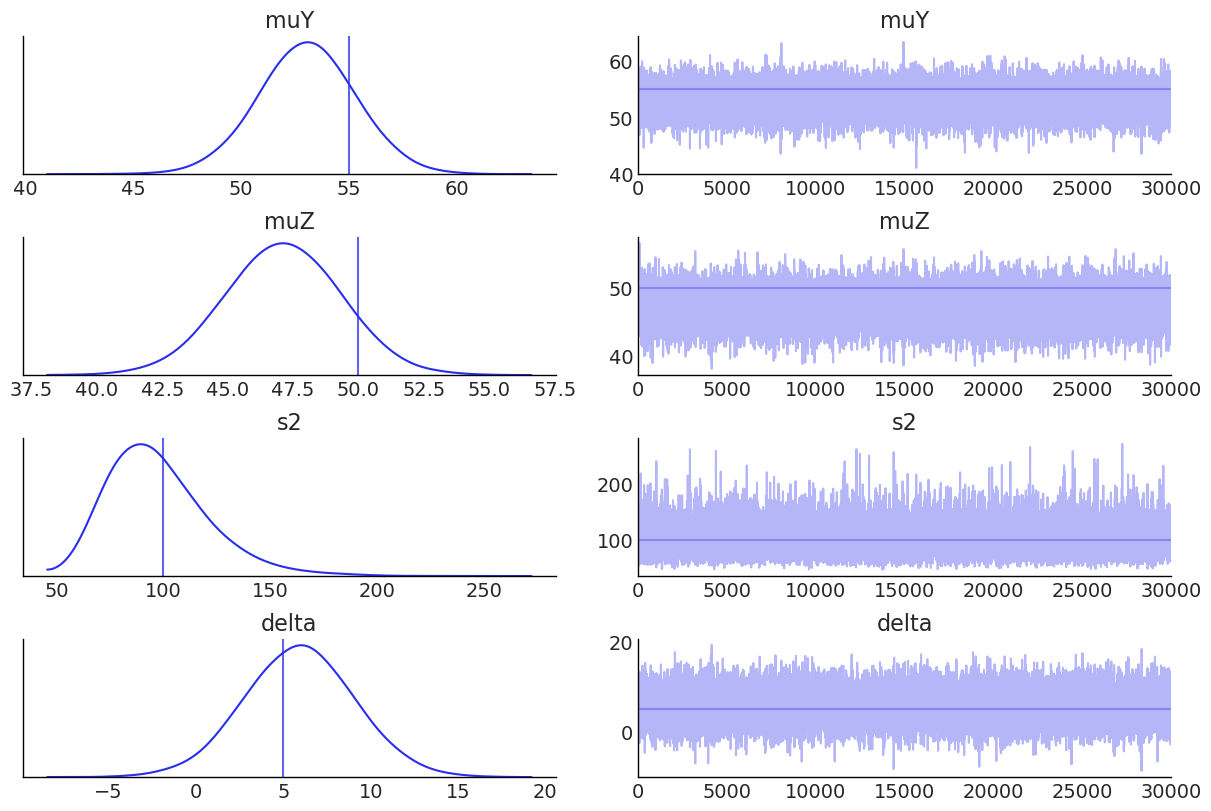

In [6]:
lines = (('muY', {}, [muY_true]),
         ('muZ', {}, [muZ_true]),
         ('s2', {}, [s2_true]),
         ('delta', {}, [muY_true-muZ_true]))

az.plot_trace(keepers, lines=lines);

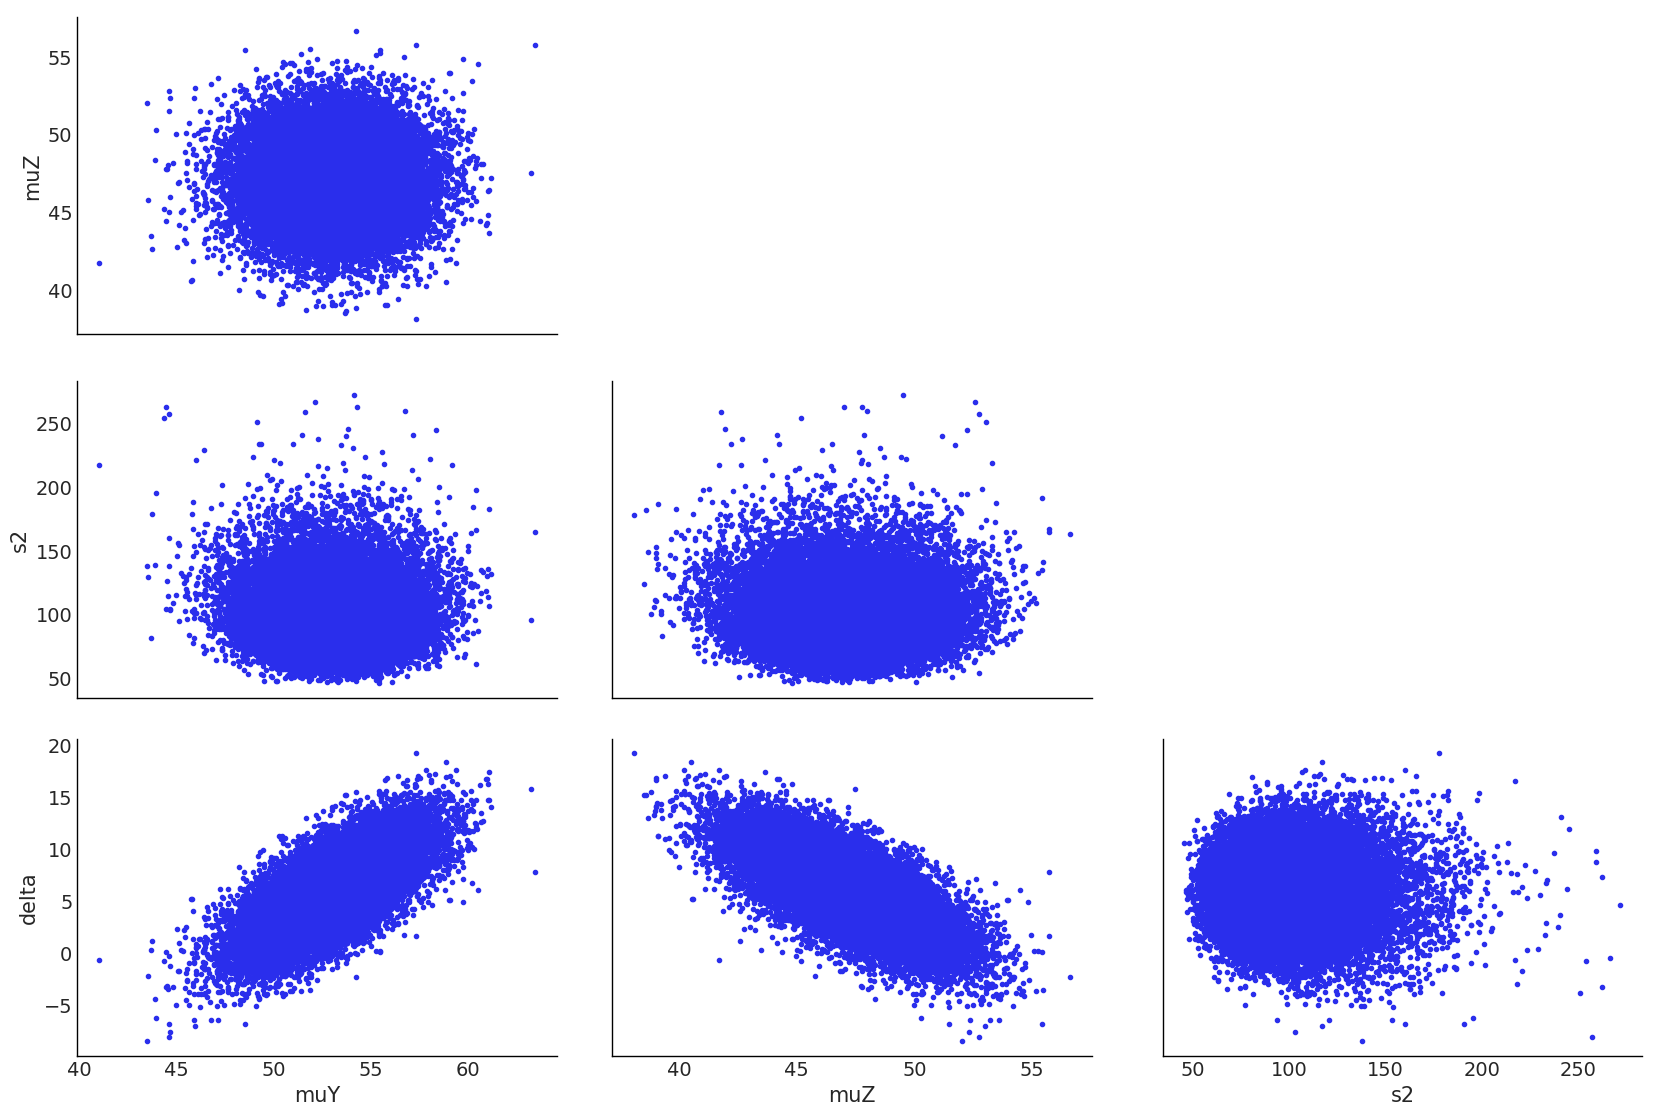

In [7]:
az.plot_pair(keepers);

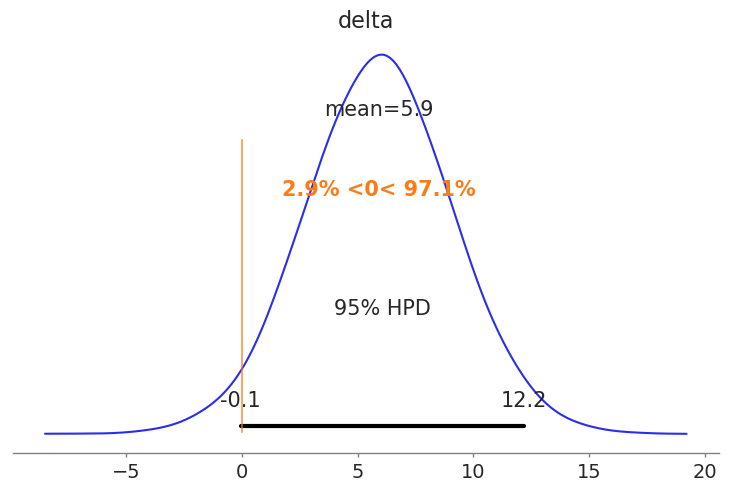

In [8]:
az.plot_posterior(keepers, var_names='delta',
                  ref_val=0, credible_interval=0.95);

In [9]:
az.hpd(keepers['delta'], credible_interval=0.95)  # Posterior 95% credible set

array([-0.05917932, 12.19730516])